# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

### lightgbm deberta-large 5folds (nestimatorふやしてみた)

In [1]:
! nvidia-smi

Tue May 10 08:59:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Directory settings

In [2]:
# ====================================================
# Directory settings
# ====================================================
import os
import sys
import json
# INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
# OUTPUT_DIR = './'
# if not os.path.exists(OUTPUT_DIR):
#     os.makedirs(OUTPUT_DIR)

# CFG

In [3]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=False
    competition='PPPM'
    _wandb_kernel='nakama'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    model="microsoft/deberta-v3-large"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=4
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=16
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    train=True

    name = "exp005" # 実験のたびにコピーしてここの名前を変えて実行するとoutputが別のファイルに保存される
    api_path = "/content/drive/MyDrive/kaggle/kaggle.json"
    drive_path = "/content/drive/MyDrive/kaggle/PPPM"
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [4]:
COLAB = "google.colab" in sys.modules

In [5]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 4.1 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=127f0659e2b2b5e0dee485c8ee297b2d7d8aeae159defb65f9c69e92274abd74
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [6]:
if COLAB:
    print("This environment is Google Colab")
    
    # mount
    from google.colab import drive
    if not os.path.isdir("/content/drive"):
        drive.mount('/content/drive') 
	
    
    # use kaggle api (need kaggle token)
    f = open(CFG.api_path, 'r')
    json_data = json.load(f) 
    os.environ["KAGGLE_USERNAME"] = json_data["username"]
    os.environ["KAGGLE_KEY"] = json_data["key"]
    
    # set dirs
    DRIVE = CFG.drive_path
    EXP = CFG.name
    INPUT_DIR = os.path.join(DRIVE, "Input")
    OUTPUT_DIR = os.path.join(DRIVE, "Output")
    SCRIPT = os.path.join(DRIVE, "Script")
    OUTPUT_DIR = os.path.join(OUTPUT_DIR, EXP) 
    # EXP_MODEL = os.path.join(OUTPUT_EXP, "model")
    # EXP_FIG = os.path.join(OUTPUT_EXP, "fig")
    # EXP_PREDS = os.path.join(OUTPUT_EXP, "preds")

    # make dirs
    for d in [INPUT_DIR, SCRIPT, OUTPUT_DIR]:
        os.makedirs(d, exist_ok=True)

    if not os.path.isfile(os.path.join(INPUT_DIR, "us-patent-phrase-to-phrase-matching.zip")):
        # load dataset
        ! kaggle competitions download -c us-patent-phrase-to-phrase-matching -p $INPUT_DIR 
        unzip_file = os.path.join(INPUT_DIR, 'us-patent-phrase-to-phrase-matching.zip')
        ! unzip $unzip_file -d $INPUT_DIR
    
    if not os.path.isfile(os.path.join(INPUT_DIR, "cpc-data.zip")):
        # load dataset
        ! kaggle datasets download -d yasufuminakama/cpc-data -p $INPUT_DIR
        unzip_file = os.path.join(INPUT_DIR, 'cpc-data.zip')
        ! unzip $unzip_file -d $INPUT_DIR

else:
    print("This environment is Kaggle Kernel")
    
    # set dirs
    INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
    OUTPUT_DIR = './'
    
    
    # # copy dirs
    # if Config.kaggle_dataset_path is not None:
    #     KD_MODEL = os.path.join(Config.kaggle_dataset_path, "model")
    #     KD_EXP_PREDS = os.path.join(Config.kaggle_dataset_path, "preds")
    #     shutil.copytree(KD_MODEL, EXP_MODEL)
    #     shutil.copytree(KD_EXP_PREDS, EXP_PREDS)

    # # make dirs
    # for d in [EXP_MODEL, EXP_FIG, EXP_PREDS]:
    #     os.makedirs(d, exist_ok=True)
        
    

This environment is Google Colab
Mounted at /content/drive


In [7]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    import wandb

    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        secret_value_0 = user_secrets.get_secret("wandb_api")
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-Public', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

# Library

In [8]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
# !pip install transformers==4.18.0
!pip install transformers[sentencepiece]
!pip install tokenizers==0.12.1
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

import lightgbm as lgb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
     |████████████████████████████████| 4.0 MB 4.6 MB/s 
     |████████████████████████████████| 596 kB 34.4 MB/s 
     |████████████████████████████████| 880 kB 39.2 MB/s 
     |████████████████████████████████| 77 kB 5.3 MB/s 
     |████████████████████████████████| 6.6 MB 33.0 MB/s 
     |████████████████████████████████| 1.2 MB 33.9 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=7cd0376578add99a435b2f208d74691145f82332af966f322675a3174b1d8adc
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


# Utils

In [9]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'/train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [10]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'/train.csv')
test = pd.read_csv(INPUT_DIR+'/test.csv')
submission = pd.read_csv(INPUT_DIR+'/sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [11]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    if COLAB:
        cpcpath = os.path.join(INPUT_DIR, 'CPCSchemeXML202105')
    else:
        cpcpath = '../input/cpc-data/CPCSchemeXML202105'
    for file_name in os.listdir(cpcpath):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        if COLAB:
            cpcpath = os.path.join(INPUT_DIR, f'CPCTitleList202202/cpc-section-{cpc}_20220201.txt')
        else:
            cpcpath = f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt'
        with open(cpcpath) as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"/cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [12]:
train['text'] = train['anchor'] + '[SEP]' + train['target'] + '[SEP]'  + train['context_text']
test['text'] = test['anchor'] + '[SEP]' + test['target'] + '[SEP]'  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region[SEP]HUMAN NECESSIT...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural netwo...


# EDA

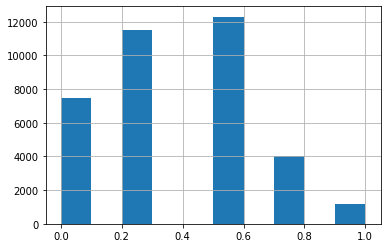

In [13]:
train['score'].hist()

In [14]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [15]:
# ====================================================
# CV split
# ====================================================
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    9119
1    9118
2    9118
3    9118
dtype: int64

In [16]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [17]:
# ====================================================
# tokenizer
# ====================================================
! pip install sentencepiece
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'/tokenizer/')
CFG.tokenizer = tokenizer

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/580 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [18]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 133


In [19]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [20]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [21]:
class TransformerHead(nn.Module):
    def __init__(self, in_features, max_length, num_layers=1, nhead=8, num_targets=1):
        super().__init__()
        # in_features は各トークンに対するベクトルの次元数
        # max_length は最大トークン数
        self.transformer = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=in_features,
                                                                                          nhead=nhead),
                                                 num_layers=num_layers)
        self.row_fc = nn.Linear(in_features, 1)
        self.out_features = max_length

    def forward(self, x):
        out = self.transformer(x)
        out = self.row_fc(out).squeeze(-1)
        return out

In [22]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        
        in_features = self.config.hidden_size
        self.attention = TransformerHead(in_features=in_features, max_length=cfg.max_len, num_layers=1, nhead=8, num_targets=1)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.attention.out_features, self.cfg.target_size)
        self._init_weights(self.fc)
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        feature = self.attention(last_hidden_states)
        
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
#         print(feature.shape)
        output = self.fc(self.fc_dropout(feature))
        return output, feature

# Helpler functions

In [23]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds, _ = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds, _ = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds, _ = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [24]:
# ### lightgbm
# ### 適当なやつ
# def train_fn_(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
#     from lightgbm import LGBMRegressor
#     model.eval()

#     embeds = []
#     targets = []
#     for step, (inputs, labels) in enumerate(train_loader):
#         for k, v in inputs.items():
#             inputs[k] = v.to(device)
#         labels = labels.to(device)
#         with torch.no_grad():
#             y_preds, embed = model(inputs)
#         embeds.append(embed.to('cpu').numpy())
#         targets.append(labels.to('cpu').numpy())
#     embeds = np.concatenate(embeds) # (datasize, 768)
#     targets = np.concatenate(targets) # (datasize, 1)
    
#     params = {
#     'objective': 'regression',
#     'boosting_type': 'gbdt',  # default = 'gbdt'
#     'num_leaves': 2**8-1, #63,         # default = 31,
#     'learning_rate': 0.01,    # default = 0.1
#     'feature_fraction': 0.8,  # default = 1.0
#     'bagging_freq': 1,        # default = 0
#     'bagging_fraction': 0.8,  # default = 1.0
#     'random_state': 0,        # default = None
#     'max_depth': 8,
# #     'min_data_in_leaf': 50,   # default = 20
#     'verbosity': -1,
# }
    

#     train_data = lgb.Dataset(
#         data=embeds, 
#         label=targets, 
#     )

#     bst = lgb.train(params=params, 
#                     train_set=train_data, 
#                     num_boost_round=600)

#     return bst

# def valid_fn_(valid_loader, model, criterion, device, gbdt):
#     model.eval()
#     preds = []
#     embeds = []
#     for step, (inputs, labels) in enumerate(valid_loader):
#         for k, v in inputs.items():
#             inputs[k] = v.to(device)
#         labels = labels.to(device)
#         with torch.no_grad():
#             _, embed = model(inputs)
#         y_preds = gbdt.predict(embed.to('cpu').numpy())
#         preds.append(y_preds)

#     predictions = np.concatenate(preds)
# #     predictions = np.concatenate(predictions)
#     return predictions


# # ====================================================
# # train loop
# # ====================================================
# def train_loop(folds, fold):
    
#     LOGGER.info(f"========== fold: {fold} training ==========")

#     # ====================================================
#     # loader
#     # ====================================================
#     train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
#     valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
#     valid_labels = valid_folds['score'].values
    
#     train_dataset = TrainDataset(CFG, train_folds)
#     valid_dataset = TrainDataset(CFG, valid_folds)

#     train_loader = DataLoader(train_dataset,
#                               batch_size=CFG.batch_size,
#                               shuffle=True,
#                               num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
#     valid_loader = DataLoader(valid_dataset,
#                               batch_size=CFG.batch_size,
#                               shuffle=False,
#                               num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

#     # ====================================================
#     # model & optimizer
#     # ====================================================
#     model = CustomModel(CFG, config_path=None, pretrained=True)
#     torch.save(model.config, OUTPUT_DIR+'/config.pth')
#     model.to(device)
    
#     def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
#         param_optimizer = list(model.named_parameters())
#         no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
#         optimizer_parameters = [
#             {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
#              'lr': encoder_lr, 'weight_decay': weight_decay},
#             {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
#              'lr': encoder_lr, 'weight_decay': 0.0},
#             {'params': [p for n, p in model.named_parameters() if "model" not in n],
#              'lr': decoder_lr, 'weight_decay': 0.0}
#         ]
#         return optimizer_parameters

#     optimizer_parameters = get_optimizer_params(model,
#                                                 encoder_lr=CFG.encoder_lr, 
#                                                 decoder_lr=CFG.decoder_lr,
#                                                 weight_decay=CFG.weight_decay)
#     optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
#     # ====================================================
#     # scheduler
#     # ====================================================
#     def get_scheduler(cfg, optimizer, num_train_steps):
#         if cfg.scheduler == 'linear':
#             scheduler = get_linear_schedule_with_warmup(
#                 optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
#             )
#         elif cfg.scheduler == 'cosine':
#             scheduler = get_cosine_schedule_with_warmup(
#                 optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
#             )
#         return scheduler
    
#     num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
#     scheduler = get_scheduler(CFG, optimizer, num_train_steps)

#     # ====================================================
#     # loop
#     # ====================================================
#     criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
#     best_score = 0.

#     for epoch in range(CFG.epochs):

#         start_time = time.time()

#         # train
#         avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)
        
#         # lightgbm train
#         gbdt = train_fn_(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

#         # eval
#         predictions = valid_fn_(valid_loader, model, criterion, device, gbdt)
        
#         # scoring
#         score = get_score(valid_labels, predictions)

#         elapsed = time.time() - start_time

# #         LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
#         LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
#         if CFG.wandb:
#             wandb.log({f"[fold{fold}] epoch": epoch+1, 
#                        f"[fold{fold}] avg_train_loss": avg_loss, 
#                        f"[fold{fold}] avg_val_loss": avg_val_loss,
#                        f"[fold{fold}] score": score})
        
#         if best_score < score:
#             best_score = score
#             torch.save({'model': model.state_dict(),
#                         'predictions': predictions},
#                         OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
#             gbdt.save_model(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_best_gbdt.txt")

#     predictions = torch.load(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
#                              map_location=torch.device('cpu'))['predictions'] #bestmodelのpredictionをとりだす
#     ### round
# #     predictions *= 4
# #     predictions = predictions.round() / 4
#     valid_folds['pred'] = predictions
#     valid_folds['pred'].hist(bins=100)

#     torch.cuda.empty_cache()
#     gc.collect()
    
#     return valid_folds


In [25]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'/config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler

    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
            
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    ### round
#     predictions *= 4
#     predictions = predictions.round() / 4
    valid_folds['pred'] = predictions
    valid_folds['pred'].hist(bins=100)

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

========== fold: 0 training ==========


Downloading:   0%|          | 0.00/833M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1709] Elapsed 0m 1s (remain 43m 19s) Loss: 0.6821(0.6821) Grad: 67482.4219  LR: 0.00002000  
Epoch: [1][100/1709] Elapsed 1m 39s (remain 26m 29s) Loss: 0.6751(0.6559) Grad: 89946.8359  LR: 0.00001999  
Epoch: [1][200/1709] Elapsed 3m 17s (remain 24m 39s) Loss: 0.6558(0.6497) Grad: 72485.8047  LR: 0.00001996  
Epoch: [1][300/1709] Elapsed 4m 54s (remain 22m 58s) Loss: 0.5020(0.6371) Grad: 172292.1875  LR: 0.00001990  
Epoch: [1][400/1709] Elapsed 6m 32s (remain 21m 18s) Loss: 0.5841(0.6270) Grad: 159392.0469  LR: 0.00001983  
Epoch: [1][500/1709] Elapsed 8m 9s (remain 19m 40s) Loss: 0.6061(0.6202) Grad: 117029.0938  LR: 0.00001974  
Epoch: [1][600/1709] Elapsed 9m 46s (remain 18m 2s) Loss: 0.5303(0.6114) Grad: 145756.1562  LR: 0.00001962  
Epoch: [1][700/1709] Elapsed 11m 24s (remain 16m 24s) Loss: 0.6076(0.6065) Grad: 74648.5625  LR: 0.00001949  
Epoch: [1][800/1709] Elapsed 13m 1s (remain 14m 46s) Loss: 0.6886(0.6032) Grad: 121165.0547  LR: 0.00001933  
Epoch: [1][900/170

Epoch 1 - avg_train_loss: 0.5780  avg_val_loss: 0.5389  time: 1837s
Epoch 1 - Score: 0.8407
Epoch 1 - Save Best Score: 0.8407 Model


EVAL: [569/570] Elapsed 2m 50s (remain 0m 0s) Loss: 0.5099(0.5389) 
Epoch: [2][0/1709] Elapsed 0m 1s (remain 37m 55s) Loss: 0.4910(0.4910) Grad: 81068.1797  LR: 0.00001707  
Epoch: [2][100/1709] Elapsed 1m 39s (remain 26m 29s) Loss: 0.5009(0.5361) Grad: 125088.1875  LR: 0.00001674  
Epoch: [2][200/1709] Elapsed 3m 17s (remain 24m 39s) Loss: 0.5959(0.5309) Grad: 128886.1797  LR: 0.00001639  
Epoch: [2][300/1709] Elapsed 4m 54s (remain 22m 57s) Loss: 0.5943(0.5297) Grad: 77103.5156  LR: 0.00001603  
Epoch: [2][400/1709] Elapsed 6m 32s (remain 21m 19s) Loss: 0.4666(0.5285) Grad: 327567.8125  LR: 0.00001566  
Epoch: [2][500/1709] Elapsed 8m 9s (remain 19m 40s) Loss: 0.5133(0.5280) Grad: 83505.3047  LR: 0.00001527  
Epoch: [2][600/1709] Elapsed 9m 46s (remain 18m 1s) Loss: 0.6399(0.5280) Grad: 63121.4375  LR: 0.00001488  
Epoch: [2][700/1709] Elapsed 11m 24s (remain 16m 23s) Loss: 0.5865(0.5294) Grad: 80109.4219  LR: 0.00001447  
Epoch: [2][800/1709] Elapsed 13m 1s (remain 14m 45s) Loss: 0.

Epoch 2 - avg_train_loss: 0.5284  avg_val_loss: 0.5373  time: 1836s
Epoch 2 - Score: 0.8545
Epoch 2 - Save Best Score: 0.8545 Model


EVAL: [569/570] Elapsed 2m 50s (remain 0m 0s) Loss: 0.4845(0.5373) 
Epoch: [3][0/1709] Elapsed 0m 1s (remain 37m 21s) Loss: 0.5659(0.5659) Grad: 58039.2422  LR: 0.00001000  
Epoch: [3][100/1709] Elapsed 1m 39s (remain 26m 22s) Loss: 0.4909(0.5143) Grad: 145254.1406  LR: 0.00000954  
Epoch: [3][200/1709] Elapsed 3m 16s (remain 24m 36s) Loss: 0.5055(0.5197) Grad: 87973.2734  LR: 0.00000908  
Epoch: [3][300/1709] Elapsed 4m 54s (remain 22m 55s) Loss: 0.5148(0.5188) Grad: 40962.5117  LR: 0.00000863  
Epoch: [3][400/1709] Elapsed 6m 31s (remain 21m 17s) Loss: 0.4775(0.5159) Grad: 93338.9609  LR: 0.00000817  
Epoch: [3][500/1709] Elapsed 8m 8s (remain 19m 38s) Loss: 0.5296(0.5127) Grad: 124877.9844  LR: 0.00000772  
Epoch: [3][600/1709] Elapsed 9m 46s (remain 18m 0s) Loss: 0.3670(0.5109) Grad: 207883.0000  LR: 0.00000728  
Epoch: [3][700/1709] Elapsed 11m 23s (remain 16m 22s) Loss: 0.4759(0.5112) Grad: 41660.5156  LR: 0.00000684  
Epoch: [3][800/1709] Elapsed 13m 0s (remain 14m 45s) Loss: 0.

Epoch 3 - avg_train_loss: 0.5113  avg_val_loss: 0.5436  time: 1836s
Epoch 3 - Score: 0.8604
Epoch 3 - Save Best Score: 0.8604 Model


EVAL: [569/570] Elapsed 2m 50s (remain 0m 0s) Loss: 0.4887(0.5436) 
Epoch: [4][0/1709] Elapsed 0m 1s (remain 38m 28s) Loss: 0.5523(0.5523) Grad: 38329.2461  LR: 0.00000293  
Epoch: [4][100/1709] Elapsed 1m 39s (remain 26m 23s) Loss: 0.5454(0.4957) Grad: 34552.6953  LR: 0.00000261  
Epoch: [4][200/1709] Elapsed 3m 16s (remain 24m 37s) Loss: 0.3938(0.4956) Grad: 52820.7539  LR: 0.00000231  
Epoch: [4][300/1709] Elapsed 4m 54s (remain 22m 56s) Loss: 0.4785(0.4980) Grad: 41011.5859  LR: 0.00000203  
Epoch: [4][400/1709] Elapsed 6m 31s (remain 21m 18s) Loss: 0.3034(0.4986) Grad: 158755.7031  LR: 0.00000176  
Epoch: [4][500/1709] Elapsed 8m 9s (remain 19m 39s) Loss: 0.4292(0.5010) Grad: 106268.9844  LR: 0.00000151  
Epoch: [4][600/1709] Elapsed 9m 46s (remain 18m 1s) Loss: 0.5039(0.5025) Grad: 103083.8828  LR: 0.00000127  
Epoch: [4][700/1709] Elapsed 11m 24s (remain 16m 23s) Loss: 0.5000(0.5023) Grad: 37190.5430  LR: 0.00000106  
Epoch: [4][800/1709] Elapsed 13m 1s (remain 14m 45s) Loss: 0.

Epoch 4 - avg_train_loss: 0.5031  avg_val_loss: 0.5436  time: 1837s
Epoch 4 - Score: 0.8619
Epoch 4 - Save Best Score: 0.8619 Model


EVAL: [569/570] Elapsed 2m 50s (remain 0m 0s) Loss: 0.4903(0.5436) 


========== fold: 0 result ==========
Score: 0.8619
========== fold: 1 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/1709] Elapsed 0m 1s (remain 49m 28s) Loss: 0.6957(0.6957) Grad: 60697.0312  LR: 0.00002000  
Epoch: [1][100/1709] Elapsed 1m 39s (remain 26m 27s) Loss: 0.6222(0.6580) Grad: 93502.0625  LR: 0.00001999  
Epoch: [1][200/1709] Elapsed 3m 17s (remain 24m 39s) Loss: 0.6708(0.6538) Grad: 142368.4219  LR: 0.00001996  
Epoch: [1][300/1709] Elapsed 4m 54s (remain 22m 57s) Loss: 0.5719(0.6455) Grad: 146065.1406  LR: 0.00001990  
Epoch: [1][400/1709] Elapsed 6m 31s (remain 21m 18s) Loss: 0.6412(0.6338) Grad: 161085.5156  LR: 0.00001983  
Epoch: [1][500/1709] Elapsed 8m 9s (remain 19m 39s) Loss: 0.6762(0.6240) Grad: 133211.9531  LR: 0.00001974  
Epoch: [1][600/1709] Elapsed 9m 46s (remain 18m 1s) Loss: 0.6510(0.6171) Grad: 80843.2891  LR: 0.00001962  
Epoch: [1][700/1709] Elapsed 11m 24s (remain 16m 23s) Loss: 0.6142(0.6115) Grad: 44218.2188  LR: 0.00001949  
Epoch: [1][800/1709] Elapsed 13m 1s (remain 14m 45s) Loss: 0.6693(0.6057) Grad: 69904.5547  LR: 0.00001933  
Epoch: [1][900/1709

Epoch 1 - avg_train_loss: 0.5794  avg_val_loss: 0.5413  time: 1837s
Epoch 1 - Score: 0.8363
Epoch 1 - Save Best Score: 0.8363 Model


Epoch: [2][0/1709] Elapsed 0m 1s (remain 37m 41s) Loss: 0.6823(0.6823) Grad: 551382.8750  LR: 0.00001707  
Epoch: [2][100/1709] Elapsed 1m 39s (remain 26m 20s) Loss: 0.5161(0.5246) Grad: 160248.2812  LR: 0.00001674  
Epoch: [2][200/1709] Elapsed 3m 16s (remain 24m 35s) Loss: 0.4001(0.5311) Grad: 72360.6562  LR: 0.00001639  
Epoch: [2][300/1709] Elapsed 4m 54s (remain 22m 55s) Loss: 0.5291(0.5328) Grad: 70443.7734  LR: 0.00001603  
Epoch: [2][400/1709] Elapsed 6m 31s (remain 21m 16s) Loss: 0.4789(0.5332) Grad: 25913.7402  LR: 0.00001566  
Epoch: [2][500/1709] Elapsed 8m 8s (remain 19m 38s) Loss: 0.4515(0.5333) Grad: 70035.6328  LR: 0.00001527  
Epoch: [2][600/1709] Elapsed 9m 46s (remain 18m 1s) Loss: 0.5115(0.5352) Grad: 58368.5508  LR: 0.00001488  
Epoch: [2][700/1709] Elapsed 11m 23s (remain 16m 23s) Loss: 0.5389(0.5347) Grad: 115004.7109  LR: 0.00001447  
Epoch: [2][800/1709] Elapsed 13m 1s (remain 14m 45s) Loss: 0.5158(0.5347) Grad: 53164.4453  LR: 0.00001406  
Epoch: [2][900/1709]

Epoch 2 - avg_train_loss: 0.5302  avg_val_loss: 0.5366  time: 1837s
Epoch 2 - Score: 0.8517
Epoch 2 - Save Best Score: 0.8517 Model


EVAL: [569/570] Elapsed 2m 50s (remain 0m 0s) Loss: 0.3788(0.5366) 
Epoch: [3][0/1709] Elapsed 0m 1s (remain 39m 11s) Loss: 0.5111(0.5111) Grad: 61324.8047  LR: 0.00001000  
Epoch: [3][100/1709] Elapsed 1m 39s (remain 26m 28s) Loss: 0.5094(0.5112) Grad: 208194.2969  LR: 0.00000954  
Epoch: [3][200/1709] Elapsed 3m 17s (remain 24m 39s) Loss: 0.4942(0.5100) Grad: 72089.9141  LR: 0.00000908  
Epoch: [3][300/1709] Elapsed 4m 54s (remain 22m 58s) Loss: 0.5186(0.5090) Grad: 48773.2656  LR: 0.00000863  
Epoch: [3][400/1709] Elapsed 6m 32s (remain 21m 18s) Loss: 0.5015(0.5094) Grad: 90402.5703  LR: 0.00000817  
Epoch: [3][500/1709] Elapsed 8m 9s (remain 19m 40s) Loss: 0.6562(0.5075) Grad: 165005.3125  LR: 0.00000772  
Epoch: [3][600/1709] Elapsed 9m 46s (remain 18m 2s) Loss: 0.4593(0.5091) Grad: 42309.5977  LR: 0.00000728  
Epoch: [3][700/1709] Elapsed 11m 24s (remain 16m 23s) Loss: 0.5331(0.5099) Grad: 53273.4062  LR: 0.00000684  
Epoch: [3][800/1709] Elapsed 13m 1s (remain 14m 46s) Loss: 0.4

Epoch 3 - avg_train_loss: 0.5107  avg_val_loss: 0.5417  time: 1837s
Epoch 3 - Score: 0.8589
Epoch 3 - Save Best Score: 0.8589 Model


EVAL: [569/570] Elapsed 2m 50s (remain 0m 0s) Loss: 0.4857(0.5417) 
Epoch: [4][0/1709] Elapsed 0m 1s (remain 38m 38s) Loss: 0.4798(0.4798) Grad: 91756.9844  LR: 0.00000293  
Epoch: [4][100/1709] Elapsed 1m 39s (remain 26m 23s) Loss: 0.4419(0.5024) Grad: 71838.2891  LR: 0.00000261  
Epoch: [4][200/1709] Elapsed 3m 16s (remain 24m 37s) Loss: 0.4858(0.5006) Grad: 64471.6211  LR: 0.00000231  
Epoch: [4][300/1709] Elapsed 4m 54s (remain 22m 56s) Loss: 0.5024(0.4974) Grad: 64957.8789  LR: 0.00000203  
Epoch: [4][400/1709] Elapsed 6m 31s (remain 21m 17s) Loss: 0.4961(0.5015) Grad: 80724.9922  LR: 0.00000176  
Epoch: [4][500/1709] Elapsed 8m 9s (remain 19m 39s) Loss: 0.4740(0.5018) Grad: 26924.1934  LR: 0.00000151  
Epoch: [4][600/1709] Elapsed 9m 46s (remain 18m 1s) Loss: 0.5022(0.5005) Grad: 24178.1230  LR: 0.00000127  
Epoch: [4][700/1709] Elapsed 11m 24s (remain 16m 23s) Loss: 0.5032(0.4987) Grad: 49061.1641  LR: 0.00000106  
Epoch: [4][800/1709] Elapsed 13m 1s (remain 14m 46s) Loss: 0.553

Epoch 4 - avg_train_loss: 0.5025  avg_val_loss: 0.5447  time: 1837s
Epoch 4 - Score: 0.8593
Epoch 4 - Save Best Score: 0.8593 Model


EVAL: [569/570] Elapsed 2m 50s (remain 0m 0s) Loss: 0.5614(0.5447) 


========== fold: 1 result ==========
Score: 0.8593
========== fold: 2 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/1709] Elapsed 0m 1s (remain 53m 24s) Loss: 0.6965(0.6965) Grad: 41278.3906  LR: 0.00002000  
Epoch: [1][100/1709] Elapsed 1m 39s (remain 26m 29s) Loss: 0.6052(0.6684) Grad: 195688.0000  LR: 0.00001999  
Epoch: [1][200/1709] Elapsed 3m 17s (remain 24m 40s) Loss: 0.6047(0.6613) Grad: 140825.3750  LR: 0.00001996  
Epoch: [1][300/1709] Elapsed 4m 54s (remain 22m 58s) Loss: 0.7487(0.6574) Grad: 204293.1094  LR: 0.00001990  
Epoch: [1][400/1709] Elapsed 6m 32s (remain 21m 19s) Loss: 0.7117(0.6466) Grad: 130730.8203  LR: 0.00001983  
Epoch: [1][500/1709] Elapsed 8m 9s (remain 19m 40s) Loss: 0.5557(0.6377) Grad: 52904.3828  LR: 0.00001974  
Epoch: [1][600/1709] Elapsed 9m 47s (remain 18m 2s) Loss: 0.6152(0.6308) Grad: 84584.3359  LR: 0.00001962  
Epoch: [1][700/1709] Elapsed 11m 24s (remain 16m 24s) Loss: 0.5629(0.6235) Grad: 71287.0156  LR: 0.00001949  
Epoch: [1][800/1709] Elapsed 13m 1s (remain 14m 46s) Loss: 0.6353(0.6167) Grad: 83500.7344  LR: 0.00001933  
Epoch: [1][900/1709

Epoch 1 - avg_train_loss: 0.5856  avg_val_loss: 0.5456  time: 1838s
Epoch 1 - Score: 0.8208
Epoch 1 - Save Best Score: 0.8208 Model


Epoch: [2][0/1709] Elapsed 0m 1s (remain 39m 46s) Loss: 0.4813(0.4813) Grad: 111341.3281  LR: 0.00001707  
Epoch: [2][100/1709] Elapsed 1m 39s (remain 26m 25s) Loss: 0.5603(0.5283) Grad: 38736.7578  LR: 0.00001674  
Epoch: [2][200/1709] Elapsed 3m 16s (remain 24m 37s) Loss: 0.5742(0.5296) Grad: 31280.6816  LR: 0.00001639  
Epoch: [2][300/1709] Elapsed 4m 54s (remain 22m 57s) Loss: 0.4665(0.5309) Grad: 63138.9805  LR: 0.00001603  
Epoch: [2][400/1709] Elapsed 6m 31s (remain 21m 18s) Loss: 0.3712(0.5302) Grad: 39961.3555  LR: 0.00001566  
Epoch: [2][500/1709] Elapsed 8m 9s (remain 19m 39s) Loss: 0.5457(0.5287) Grad: 109792.8047  LR: 0.00001527  
Epoch: [2][600/1709] Elapsed 9m 47s (remain 18m 2s) Loss: 0.7611(0.5294) Grad: 213481.3438  LR: 0.00001488  
Epoch: [2][700/1709] Elapsed 11m 24s (remain 16m 24s) Loss: 0.5334(0.5305) Grad: 50031.8555  LR: 0.00001447  
Epoch: [2][800/1709] Elapsed 13m 1s (remain 14m 46s) Loss: 0.5453(0.5303) Grad: 40476.9805  LR: 0.00001406  
Epoch: [2][900/1709]

Epoch 2 - avg_train_loss: 0.5321  avg_val_loss: 0.5432  time: 1835s
Epoch 2 - Score: 0.8437
Epoch 2 - Save Best Score: 0.8437 Model


EVAL: [569/570] Elapsed 2m 50s (remain 0m 0s) Loss: 0.4764(0.5432) 
Epoch: [3][0/1709] Elapsed 0m 1s (remain 39m 5s) Loss: 0.3102(0.3102) Grad: 66837.9062  LR: 0.00001000  
Epoch: [3][100/1709] Elapsed 1m 39s (remain 26m 22s) Loss: 0.5567(0.5158) Grad: 60529.2109  LR: 0.00000954  
Epoch: [3][200/1709] Elapsed 3m 16s (remain 24m 34s) Loss: 0.5985(0.5151) Grad: 51630.7383  LR: 0.00000908  
Epoch: [3][300/1709] Elapsed 4m 53s (remain 22m 53s) Loss: 0.4801(0.5151) Grad: 91320.2266  LR: 0.00000863  
Epoch: [3][400/1709] Elapsed 6m 30s (remain 21m 13s) Loss: 0.6078(0.5155) Grad: 38959.4922  LR: 0.00000817  
Epoch: [3][500/1709] Elapsed 8m 7s (remain 19m 35s) Loss: 0.4749(0.5145) Grad: 85985.6172  LR: 0.00000772  
Epoch: [3][600/1709] Elapsed 9m 44s (remain 17m 57s) Loss: 0.5433(0.5157) Grad: 137670.6250  LR: 0.00000728  
Epoch: [3][700/1709] Elapsed 11m 21s (remain 16m 20s) Loss: 0.4799(0.5137) Grad: 59179.2188  LR: 0.00000684  
Epoch: [3][800/1709] Elapsed 12m 58s (remain 14m 43s) Loss: 0.5

Epoch 3 - avg_train_loss: 0.5107  avg_val_loss: 0.5398  time: 1831s
Epoch 3 - Score: 0.8568
Epoch 3 - Save Best Score: 0.8568 Model


EVAL: [569/570] Elapsed 2m 50s (remain 0m 0s) Loss: 0.4692(0.5398) 
Epoch: [4][0/1709] Elapsed 0m 1s (remain 38m 18s) Loss: 0.6421(0.6421) Grad: 39661.4844  LR: 0.00000293  
Epoch: [4][100/1709] Elapsed 1m 39s (remain 26m 17s) Loss: 0.4933(0.5097) Grad: 60684.9805  LR: 0.00000261  
Epoch: [4][200/1709] Elapsed 3m 16s (remain 24m 31s) Loss: 0.4952(0.5123) Grad: 69628.8047  LR: 0.00000231  
Epoch: [4][300/1709] Elapsed 4m 53s (remain 22m 50s) Loss: 0.5650(0.5125) Grad: 34361.4570  LR: 0.00000203  
Epoch: [4][400/1709] Elapsed 6m 30s (remain 21m 12s) Loss: 0.5237(0.5105) Grad: 100684.0391  LR: 0.00000176  
Epoch: [4][500/1709] Elapsed 8m 6s (remain 19m 34s) Loss: 0.5620(0.5090) Grad: 38634.9531  LR: 0.00000151  
Epoch: [4][600/1709] Elapsed 9m 43s (remain 17m 56s) Loss: 0.5527(0.5084) Grad: 122099.7734  LR: 0.00000127  
Epoch: [4][700/1709] Elapsed 11m 20s (remain 16m 19s) Loss: 0.4812(0.5078) Grad: 133921.1562  LR: 0.00000106  
Epoch: [4][800/1709] Elapsed 12m 58s (remain 14m 41s) Loss: 

Epoch 4 - avg_train_loss: 0.5032  avg_val_loss: 0.5429  time: 1829s
Epoch 4 - Score: 0.8568
Epoch 4 - Save Best Score: 0.8568 Model


EVAL: [569/570] Elapsed 2m 49s (remain 0m 0s) Loss: 0.4656(0.5429) 


========== fold: 2 result ==========
Score: 0.8568
========== fold: 3 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/1709] Elapsed 0m 1s (remain 50m 24s) Loss: 0.7083(0.7083) Grad: 139043.6875  LR: 0.00002000  
Epoch: [1][100/1709] Elapsed 1m 39s (remain 26m 18s) Loss: 0.6447(0.6572) Grad: 41437.7031  LR: 0.00001999  
Epoch: [1][200/1709] Elapsed 3m 16s (remain 24m 31s) Loss: 0.7037(0.6482) Grad: 131237.8281  LR: 0.00001996  
Epoch: [1][300/1709] Elapsed 4m 53s (remain 22m 50s) Loss: 0.6427(0.6412) Grad: 19251.2109  LR: 0.00001990  
Epoch: [1][400/1709] Elapsed 6m 30s (remain 21m 12s) Loss: 0.6392(0.6281) Grad: 26382.4863  LR: 0.00001983  
Epoch: [1][500/1709] Elapsed 8m 6s (remain 19m 34s) Loss: 0.5643(0.6219) Grad: 9328.0938  LR: 0.00001974  
Epoch: [1][600/1709] Elapsed 9m 44s (remain 17m 56s) Loss: 0.6493(0.6147) Grad: 14695.2109  LR: 0.00001962  
Epoch: [1][700/1709] Elapsed 11m 21s (remain 16m 19s) Loss: 0.6559(0.6070) Grad: 11046.7266  LR: 0.00001949  
Epoch: [1][800/1709] Elapsed 12m 57s (remain 14m 41s) Loss: 0.6222(0.6013) Grad: 8088.7900  LR: 0.00001933  
Epoch: [1][900/1709] 

Epoch 1 - avg_train_loss: 0.5772  avg_val_loss: 0.5474  time: 1829s
Epoch 1 - Score: 0.8226
Epoch 1 - Save Best Score: 0.8226 Model


Epoch: [2][0/1709] Elapsed 0m 1s (remain 38m 34s) Loss: 0.5733(0.5733) Grad: 146093.4219  LR: 0.00001707  
Epoch: [2][100/1709] Elapsed 1m 39s (remain 26m 18s) Loss: 0.5894(0.5221) Grad: 348097.9062  LR: 0.00001674  
Epoch: [2][200/1709] Elapsed 3m 16s (remain 24m 32s) Loss: 0.4829(0.5276) Grad: 142584.9062  LR: 0.00001639  
Epoch: [2][300/1709] Elapsed 4m 53s (remain 22m 51s) Loss: 0.5065(0.5261) Grad: 18016.6523  LR: 0.00001603  
Epoch: [2][400/1709] Elapsed 6m 30s (remain 21m 12s) Loss: 0.5061(0.5231) Grad: 21257.8691  LR: 0.00001566  
Epoch: [2][500/1709] Elapsed 8m 7s (remain 19m 34s) Loss: 0.4841(0.5236) Grad: 29029.8984  LR: 0.00001527  
Epoch: [2][600/1709] Elapsed 9m 44s (remain 17m 56s) Loss: 0.4573(0.5253) Grad: 26212.2090  LR: 0.00001488  
Epoch: [2][700/1709] Elapsed 11m 21s (remain 16m 19s) Loss: 0.5696(0.5267) Grad: 57414.9570  LR: 0.00001447  
Epoch: [2][800/1709] Elapsed 12m 58s (remain 14m 42s) Loss: 0.5808(0.5259) Grad: 47923.4336  LR: 0.00001406  
Epoch: [2][900/170

Epoch 2 - avg_train_loss: 0.5235  avg_val_loss: 0.5411  time: 1829s
Epoch 2 - Score: 0.8459
Epoch 2 - Save Best Score: 0.8459 Model


EVAL: [569/570] Elapsed 2m 50s (remain 0m 0s) Loss: 0.4317(0.5411) 
Epoch: [3][0/1709] Elapsed 0m 1s (remain 38m 46s) Loss: 0.5390(0.5390) Grad: 35340.2695  LR: 0.00001000  
Epoch: [3][100/1709] Elapsed 1m 38s (remain 26m 15s) Loss: 0.4731(0.5103) Grad: 95704.9375  LR: 0.00000954  
Epoch: [3][200/1709] Elapsed 3m 16s (remain 24m 32s) Loss: 0.6105(0.5132) Grad: 59394.0938  LR: 0.00000908  
Epoch: [3][300/1709] Elapsed 4m 53s (remain 22m 51s) Loss: 0.4616(0.5117) Grad: 69835.5234  LR: 0.00000863  
Epoch: [3][400/1709] Elapsed 6m 30s (remain 21m 12s) Loss: 0.5497(0.5131) Grad: 67423.5938  LR: 0.00000817  
Epoch: [3][500/1709] Elapsed 8m 7s (remain 19m 34s) Loss: 0.5434(0.5118) Grad: 31097.1934  LR: 0.00000772  
Epoch: [3][600/1709] Elapsed 9m 44s (remain 17m 56s) Loss: 0.5101(0.5126) Grad: 40187.5469  LR: 0.00000728  
Epoch: [3][700/1709] Elapsed 11m 21s (remain 16m 19s) Loss: 0.6136(0.5120) Grad: 26445.8242  LR: 0.00000684  
Epoch: [3][800/1709] Elapsed 12m 58s (remain 14m 42s) Loss: 0.6

Epoch 3 - avg_train_loss: 0.5113  avg_val_loss: 0.5420  time: 1829s
Epoch 3 - Score: 0.8481
Epoch 3 - Save Best Score: 0.8481 Model


EVAL: [569/570] Elapsed 2m 49s (remain 0m 0s) Loss: 0.4326(0.5420) 
Epoch: [4][0/1709] Elapsed 0m 1s (remain 38m 3s) Loss: 0.5136(0.5136) Grad: 48930.8281  LR: 0.00000293  
Epoch: [4][100/1709] Elapsed 1m 38s (remain 26m 15s) Loss: 0.4672(0.5042) Grad: 61116.7227  LR: 0.00000261  
Epoch: [4][200/1709] Elapsed 3m 15s (remain 24m 29s) Loss: 0.4842(0.5028) Grad: 31764.5117  LR: 0.00000231  
Epoch: [4][300/1709] Elapsed 4m 52s (remain 22m 50s) Loss: 0.4487(0.5051) Grad: 23190.4258  LR: 0.00000203  
Epoch: [4][400/1709] Elapsed 6m 29s (remain 21m 11s) Loss: 0.5413(0.5058) Grad: 73854.6953  LR: 0.00000176  
Epoch: [4][500/1709] Elapsed 8m 6s (remain 19m 33s) Loss: 0.5234(0.5055) Grad: 109673.3984  LR: 0.00000151  
Epoch: [4][600/1709] Elapsed 9m 43s (remain 17m 56s) Loss: 0.5334(0.5058) Grad: 12719.5430  LR: 0.00000127  
Epoch: [4][700/1709] Elapsed 11m 20s (remain 16m 19s) Loss: 0.5293(0.5053) Grad: 26613.9258  LR: 0.00000106  
Epoch: [4][800/1709] Elapsed 12m 57s (remain 14m 41s) Loss: 0.5

Epoch 4 - avg_train_loss: 0.5052  avg_val_loss: 0.5445  time: 1832s
Epoch 4 - Score: 0.8494
Epoch 4 - Save Best Score: 0.8494 Model


EVAL: [569/570] Elapsed 2m 52s (remain 0m 0s) Loss: 0.4311(0.5445) 


========== fold: 3 result ==========
Score: 0.8494
========== CV ==========
Score: 0.8567


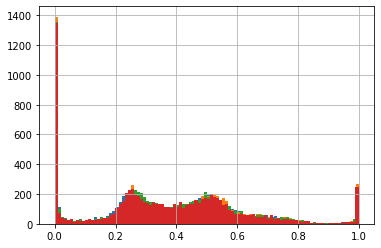

In [26]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'/oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()